# 도로 상황 분류 프로젝트

### 영상 데이터를 통한 실시간 라벨링
* 실전 Test 데이터 
* 맑은 날 주행 영상 or 비오는날 주행 영상 or 눈오는날 주행 영상이 주어졌을 때, frame별 예측!
* 총 4500개  데이터, Normal(맑음) , Rainy(비), Snowy(눈) 각 1500개

### 1. 영상 데이터 => 이미지 데이터
### 2. 이미지 데이터 => DataLoader
### 3. 모델 예측 
### 4. 예측 결과 사진에 Labeling

In [2]:
import cv2
import os
import time

print(cv2.__version__)

4.8.0


In [4]:
def videoToImage(file_path):
    
    #'' 사이에 사용할 비디오 파일의 경로 및 이름을 넣어주도록 함
    video = cv2.VideoCapture(file_path)

    length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video.get(cv2.CAP_PROP_FPS)

    print(file_path)
    print("length :", length)
    print("width :", width)
    print("height :", height)
    print("fps :", fps)
    # print('//'.join(file_path.split("//")[:-2])+'//images')

    save_path = '//'.join(file_path.split("//")[:-2])+'//images//'

    try:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
            print(save_path)
    except OSError:
        print ('Error: Creating directory. ' +  save_path)

    count = 0

    while(video.isOpened()):
        
        # Normal, Rainy, Snowy 3개 클래스 각 5000개씩(영상 시간 고려)
        ret, image = video.read()

        # if(int(video.get(1)) % fps == 0): #앞서 불러온 fps 값을 사용하여 1초마다 추출
        if(int(video.get(1)) % 20 == 0): # 5 프레임당 1개씩 추출
            cv2.imwrite(save_path + "//frame%d.jpg" % count, image)
            time.sleep(0.5)
            print(save_path + "//frame%d.jpg" % count)
            # print('Saved frame number :', str(int(video.get(1))))
            count += 1

        if count > 5399:
            break
            
    video.release()

    return save_path

root_path = 'D://Weather conditions driving classification data (All)//video_test(resnet50)//origin_videos//'

save_path = videoToImage(root_path+'All_Classes(Video_Test_20min).mp4')

D://Weather conditions driving classification data (All)//video_test(resnet50)//origin_videos//All_Classes(Video_Test_20min).mp4
length : 108565
width : 1280
height : 720
fps : 30.0
D://Weather conditions driving classification data (All)//video_test(resnet50)//images////frame0.jpg
D://Weather conditions driving classification data (All)//video_test(resnet50)//images////frame1.jpg
D://Weather conditions driving classification data (All)//video_test(resnet50)//images////frame2.jpg
D://Weather conditions driving classification data (All)//video_test(resnet50)//images////frame3.jpg
D://Weather conditions driving classification data (All)//video_test(resnet50)//images////frame4.jpg
D://Weather conditions driving classification data (All)//video_test(resnet50)//images////frame5.jpg
D://Weather conditions driving classification data (All)//video_test(resnet50)//images////frame6.jpg
D://Weather conditions driving classification data (All)//video_test(resnet50)//images////frame7.jpg
D://Weathe

In [5]:
from glob import glob

images = glob(save_path+'*.jpg')
images

['D://Weather conditions driving classification data (All)//video_test(resnet50)//images\\frame0.jpg',
 'D://Weather conditions driving classification data (All)//video_test(resnet50)//images\\frame1.jpg',
 'D://Weather conditions driving classification data (All)//video_test(resnet50)//images\\frame10.jpg',
 'D://Weather conditions driving classification data (All)//video_test(resnet50)//images\\frame100.jpg',
 'D://Weather conditions driving classification data (All)//video_test(resnet50)//images\\frame1000.jpg',
 'D://Weather conditions driving classification data (All)//video_test(resnet50)//images\\frame1001.jpg',
 'D://Weather conditions driving classification data (All)//video_test(resnet50)//images\\frame1002.jpg',
 'D://Weather conditions driving classification data (All)//video_test(resnet50)//images\\frame1003.jpg',
 'D://Weather conditions driving classification data (All)//video_test(resnet50)//images\\frame1004.jpg',
 'D://Weather conditions driving classification data (A

### transform 정의

In [6]:
# 가로로 절반으로 자르는 함수 정의
def crop_horizontal_half(img):
    width, height = img.size
    cropped_img = img.crop((0, height//2, width,height))

    return cropped_img

In [7]:
from torchvision import transforms
import torchvision


transform= transforms.Compose(
    [   
        transforms.Lambda(crop_horizontal_half),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        # transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])

    ]
)

c:\Users\user\miniconda3\envs\DL_06_22\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### DataLoader 정의

In [8]:
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import PIL

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = self.load_image(image_path)

        if self.transform:
            image = self.transform(image)

        return image

    def load_image(self, image_path):
        # 이미지 로드 로직을 구현합니다.
        # 예시로는 PIL 이미지를 사용하고, 필요에 따라 다른 라이브러리를 사용하셔도 됩니다.
        # 필요에 따라 이미지 크기 조정, 채널 변환 등의 로직을 추가할 수 있습니다.
        return PIL.Image.open(image_path).convert("RGB")

In [9]:
from torch.utils.data import DataLoader

# 이미지 파일 경로 리스트를 가정하고 시작합니다.
image_paths = images  # 이미지 파일 경로 리스트를 로드하세요.

# 데이터셋을 생성합니다.
dataset = ImageDataset(image_paths, transform=transform)

# DataLoader를 생성합니다.
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
dataloader

In [ ]:
dataloader.

In [10]:
img = next(iter(dataloader))
img

tensor([[[[0.2078, 0.2353, 0.2392,  ..., 0.2431, 0.1765, 0.2078],
          [0.2000, 0.1882, 0.1804,  ..., 0.2510, 0.2314, 0.3647],
          [0.1882, 0.1647, 0.1373,  ..., 0.2549, 0.3137, 0.4549],
          ...,
          [0.4549, 0.4549, 0.4510,  ..., 0.4000, 0.4196, 0.4235],
          [0.4588, 0.4549, 0.4549,  ..., 0.3882, 0.4000, 0.4196],
          [0.4784, 0.4941, 0.5294,  ..., 0.4118, 0.3765, 0.4196]],

         [[0.2667, 0.2941, 0.3020,  ..., 0.2706, 0.1882, 0.2235],
          [0.2588, 0.2471, 0.2392,  ..., 0.2745, 0.2431, 0.3804],
          [0.2471, 0.2235, 0.1961,  ..., 0.2784, 0.3294, 0.4745],
          ...,
          [0.5020, 0.5020, 0.4980,  ..., 0.4353, 0.4667, 0.4706],
          [0.5059, 0.5020, 0.5020,  ..., 0.4235, 0.4510, 0.4706],
          [0.5255, 0.5412, 0.5765,  ..., 0.4431, 0.4275, 0.4706]],

         [[0.1765, 0.2039, 0.1961,  ..., 0.1765, 0.1059, 0.1529],
          [0.1725, 0.1608, 0.1412,  ..., 0.1804, 0.1608, 0.3020],
          [0.1686, 0.1373, 0.1020,  ..., 0

### 모델 로드

In [12]:
import torch
import torch.nn as nn

weight_path = 'C://backend_study//metaverse_academy//03.딥러닝//개인프로젝트//(유튜브)기상 상황 주행 분류 프로젝트//models//resnet50(video_test).pt'

model = torchvision.models.resnet50(pretrained=False)
for param in model.parameters():
  # param.requires_grad = False == > 전부 동결
  param.requires_grad = True
fc_input_features = model.fc.in_features
model.fc = nn.Linear(fc_input_features,3)

model.load_state_dict(torch.load(weight_path))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 이미지 데이터 검증 => PIL image에 예측 클래스 라벨링

In [14]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFont, ImageDraw
from matplotlib import cm
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)
model.eval()
class_names = ['Normal','Rainy','Snowy']

labeled_images_path = 'D://Weather conditions driving classification data (All)//video_test(resnet50)//labeled_images_test//'
# font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans.ttf", 25)

font_size = 40
font = ImageFont.truetype("arial.ttf", font_size)


cnt = 0
with torch.no_grad():
  for data in tqdm(dataloader):
    preds = model(data.to(device))
    pred = torch.max(preds,1)[1]
    print("preds : ",preds)
    print("pred : ", pred)
    break
    for i in range(32):

      try :
        img = np.array(data[i])
        img = (img * 255).astype(np.uint8)
        img = np.transpose(img,(1,2,0))
        pil_image=Image.fromarray(img)
        draw = ImageDraw.Draw(pil_image)
        draw.text(xy=(65,50), text=class_names[pred[i]], fill= (255,255,255),font=font)
        # print(labeled_images_path+'frame'+str(cnt)+'.jpg')
        # pil_image.save(labeled_images_path+'frame'+str(cnt)+'.jpg')
        time.sleep(0.5)
        cnt += 1

      # 마지막 배치사이즈 안맞음
      except:
        pass

  0%|          | 0/169 [00:00<?, ?it/s]

preds :  

  0%|          | 0/169 [00:00<?, ?it/s]

tensor([[-1.5044, -3.0681,  3.5473],
        [-1.8579, -2.1729,  2.9845],
        [-3.6286, -2.4035,  4.7975],
        [-7.2370, -5.4578, 10.4592],
        [ 1.1761, -5.1899,  2.7523],
        [ 0.4446, -4.4263,  2.8102],
        [ 0.5267, -4.7713,  3.0195],
        [ 0.5351, -3.9233,  2.1089],
        [-0.2215, -3.9720,  2.8979],
        [ 0.4965, -3.7739,  2.0719],
        [ 0.7591, -3.9874,  1.9682],
        [ 1.5758, -5.0310,  2.2110],
        [ 0.3820, -3.8064,  2.1372],
        [ 1.2146, -4.4663,  1.8883],
        [-4.2030, -6.7464,  8.9742],
        [ 0.9175, -3.6213,  1.4548],
        [ 0.2645, -3.5605,  2.0258],
        [ 0.8102, -3.7002,  1.6749],
        [ 0.9914, -4.8271,  2.2530],
        [-0.1142, -3.3204,  2.2089],
        [-1.8399, -2.8673,  3.5176],
        [-1.1554, -3.3010,  3.2466],
        [-0.0694, -3.7960,  2.6839],
        [ 0.0204, -3.9187,  2.7228],
        [ 0.8735, -4.4198,  2.1765],
        [-7.8900, -6.7049, 12.1245],
        [ 0.7153, -4.4711,  2.5313],
 

### 예시

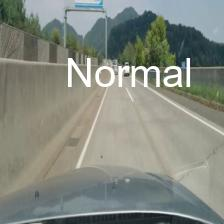 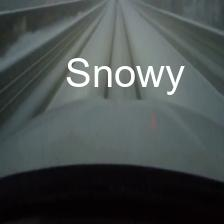 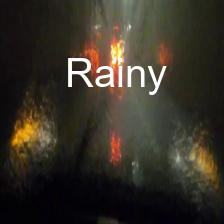 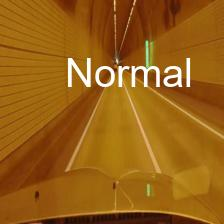 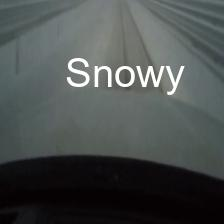 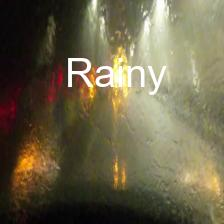